# Sentiment analysis with an LSTM


## Setup

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
dataset

{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 Split('unsupervised'): <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}

In [ ]:
tf.data.experimental.cardinality(train_dataset).numpy()

25000

In [ ]:
num_elements = len(train_dataset)
print("Number of elements in the dataset:", num_elements)

Number of elements in the dataset: 25000


Initially this returns a dataset of (text, label pairs):

In [ ]:
for example in train_dataset.take(2):  # Adjust the number as needed
    print("Example:", example)

Example: (<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
Example: (<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm 

In [ ]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [ ]:
type(train_dataset.take(2))

tensorflow.python.data.ops.take_op._TakeDataset

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I saw this film first on my way home from Paris to Newark aboard Air France in August 1996. The film itself I believe is quite a masterpiece. It's the kind of film that people should be making. I still think Daniel Auteuil is one of the sexiest actors around. In this French film, he plays a divorced father and businessman who has lost his zest for life until he across a Down Syndrome man who lives in an institution with other Down Syndrome patients. The actors including the actor who actually has Down Syndrome create a believable friendship and relationship between these two unlikely men. Daniel's life and ours changes forever with the Down Syndrome man. He realizes that life is not just work and not play but for the living and loving and that's what life should be all about. The ending is kind of silly though but I still think it's one of my favorite movies. It's enough to bring a tear to your eye."
 b"The best film about marriage and family. This is a very interesting refl

This code is just to see how buffers work on the dataset

In [ ]:
# import tensorflow as tf

# # Create a simple dataset of integers from 0 to 9
# dataset = tf.data.Dataset.range(10)

# # Define parameters
# BUFFER_SIZE = 5  # Number of elements to buffer while shuffling
# BATCH_SIZE = 2   # Number of elements in each batch

# # Shuffle, batch, and prefetch the dataset
# shuffled_batched_prefetched_dataset = (
#     dataset.shuffle(BUFFER_SIZE)
#            .batch(BATCH_SIZE)
#            .prefetch(tf.data.AUTOTUNE)
# )

# # Iterate through the dataset
# for batch in shuffled_batched_prefetched_dataset:
#     print("Batch:", batch.numpy())


Batch: [3 0]
Batch: [2 1]
Batch: [4 7]
Batch: [6 8]
Batch: [9 5]


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [ ]:
train_dataset.map(lambda text, label: text)

<_MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 208,  11, ...,   0,   0,   0],
       [  2, 115,  20, ...,   0,   0,   0],
       [  1,  11,  14, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I saw this film first on my way home from Paris to Newark aboard Air France in August 1996. The film itself I believe is quite a masterpiece. It's the kind of film that people should be making. I still think Daniel Auteuil is one of the sexiest actors around. In this French film, he plays a divorced father and businessman who has lost his zest for life until he across a Down Syndrome man who lives in an institution with other Down Syndrome patients. The actors including the actor who actually has Down Syndrome create a believable friendship and relationship between these two unlikely men. Daniel's life and ours changes forever with the Down Syndrome man. He realizes that life is not just work and not play but for the living and loving and that's what life should be all about. The ending is kind of silly though but I still think it's one of my favorite movies. It's enough to bring a tear to your eye."
Round-trip:  i saw this film first on my way home from [UNK] to [UNK] [UN

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00185956]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 95ms/step
[-0.00185955]


Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 101ms/step - loss: 0.6319 - accuracy: 0.5914 - val_loss: 0.4827 - val_accuracy: 0.7714
Epoch 2/10
391/391 [==============================] - 26s 66ms/step - loss: 0.4011 - accuracy: 0.8174 - val_loss: 0.3671 - val_accuracy: 0.8161
Epoch 3/10
391/391 [==============================] - 25s 62ms/step - loss: 0.3419 - accuracy: 0.8494 - val_loss: 0.3369 - val_accuracy: 0.8526
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3206 - accuracy: 0.8607 - val_loss: 0.3303 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3175 - accuracy: 0.8627 - val_loss: 0.3325 - val_accuracy: 0.8401
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3071 - accuracy: 0.8670 - val_loss: 0.3222 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3077 - accuracy: 0.8671 - val_loss: 0.3239 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3143 - accuracy: 0.8609
Test Loss: 0.3142525553703308
Test Accuracy: 0.8609200119972229


(0.0, 0.6716410130262375)

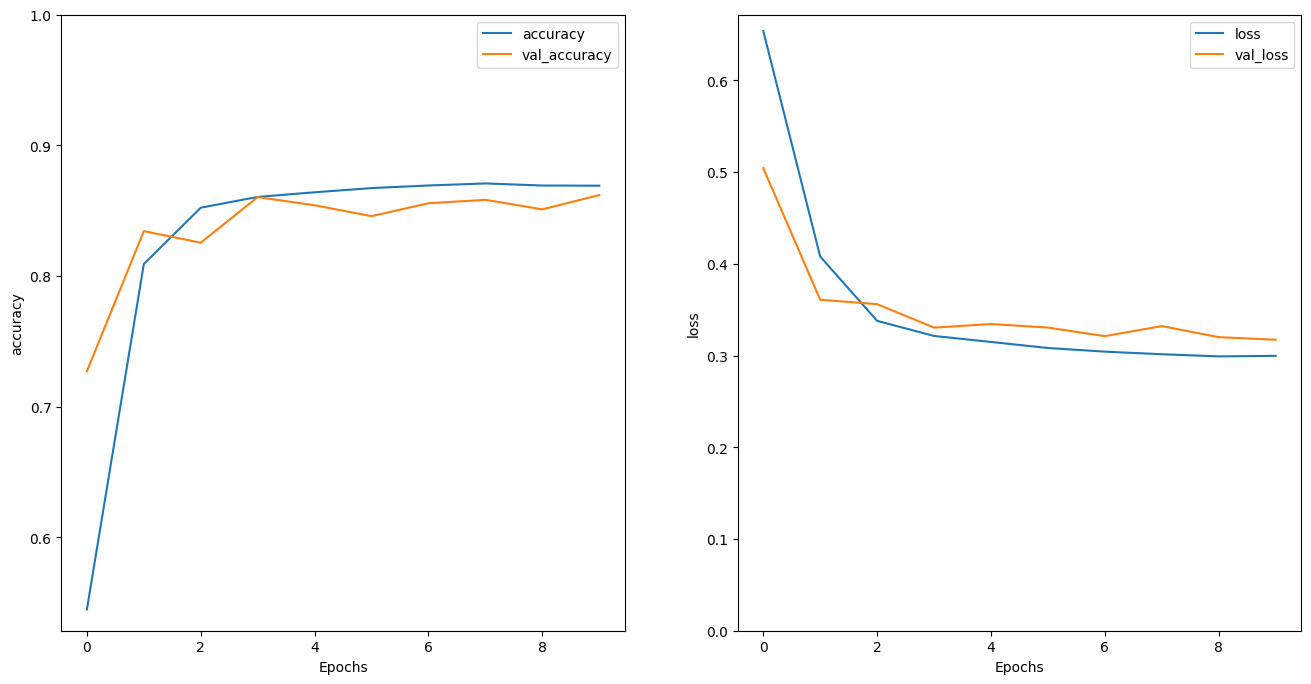

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
print(predictions[0])

[0.9830106]


In [ ]:
sample_text = ('i dont like this movie. The animation and the graphics '
               'were bad. I would never recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 20ms/step
[-0.7216321]


In [ ]:
sample_text = ("i have no comment about about this movie")
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 0s 33ms/step
[0.04610876]
